In this notebook, we are going to load some of the data that we processed in the Condensed Notebook and perform across-trial analysis of the power spectra using FOOOF, an iterative peak-detection and PSD 1/f fitting algorithm. 

Also provide options for plotting the frequency-wide and session-wide PSD by region.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import mne
import mne_connectivity
from mne_connectivity import phase_slope_index, seed_target_indices, spectral_connectivity_epochs
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import fooof
# Import plotting functions
from fooof.plts.spectra import plot_spectrum, plot_spectra
# Import the FOOOF object
from fooof import FOOOF
from fooof import FOOOFGroup
import os 
import joblib
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import warnings 

# I only want to see warnings once
warnings.filterwarnings('ignore')

from joblib import delayed, Parallel
from statsmodels.stats import multitest

from neurodsp.plts.spectral import plot_power_spectra


Note: If you have installed this package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [5]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')

In [6]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils, oscillation_utils, statistics_utils


Before running the following, you need to: 

1. Load relevant behavioral data produced from your proprietary behavioral analyses.
1. Load neural epochs of behavioral interest produced from the Condensed Notebook.

## First, get the behavior data

This is from another notebook with a kernel and environment specifically for beahvior

In [7]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results
load_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU'

# Load the demographics data to get information about who has run the task
demo_file = f'{base_dir}/projects/guLab/Salman/EMU/MemoryBanditsDatabase.xlsx'
demo_data = pd.read_excel(demo_file, engine='openpyxl')
subj_df = demo_data[(demo_data.LongVersion==1) & (demo_data.Minerva==1)]

# Let's get rid of Iowa patients for now 

# subj_df = subj_df[subj_df.Site=='UI']

subj_df = subj_df[~subj_df['MSSMCode'].isin(['MS015', 'MS024', 'MS034', 'MS038'])]


days = ['Day1', 'Day2']
subj_ids = subj_df.MSSMCode.values
subj_formats = subj_df.format.values
subj_sites = subj_df.Site.values
subj_days = subj_df.Day2.values

In [8]:
# load behavioral data
learn_df = pd.read_csv(f'{load_dir}/learn_df.csv')
combined_df = pd.read_csv(f'{load_dir}/combined_df.csv')

# Filter just to the participants in this notebook
learn_df = learn_df[learn_df.participant.isin(subj_ids)]
combined_df = combined_df[combined_df.participant.isin(subj_ids)]


# I enter the day information in stupidly 
combined_df.condition = combined_df.condition.apply(lambda x: 'Day1' if x=='day_1' else 'Day2' if x=='day_2' else np.nan)
combined_df['recog_time'] = combined_df['recog_time'].apply(lambda x: float(x) if (~pd.isna(x)) & (x!='None') else x)
combined_df['baseline_start_mem'] = combined_df['baseline_start_mem'].apply(lambda x: float(x) if (~pd.isna(x)) & (x!='None') else x)

# add RPE to the combined df dataframe: 

combined_df['rpe'] = np.nan
for ix, row in learn_df.iterrows():
    combined_df.loc[(combined_df.img_path==row.img_path) & (combined_df.participant==row.participant), 'rpe'] = row.rpe

## Plot the power spec by region

Before using FOOOF to compute peak properties constrained to lower frequencies, let's first just plot the power spectra in a region-specific manner, normalizing for comparison across participants: 

In [99]:
%%time
# select event of interest
ev_dict = {'feedback_start': [0, 1.5]}

# select ROI
rois = ['HPC', 'AMY', 'OFC', 'dmPFC', 'ACC'] 

progress_bar = tqdm(subj_ids, ascii=True, desc='Computing PSD for all trials and subsetting by conditions')

psd_group_data = {f'{a}': [] for a in rois}

for subj_id in progress_bar:
    # Load one person's data 
    for day in ['Day1']:
        load_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
        for event in ev_dict.keys():   
            filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/FOOOF/{event}'
            if not os.path.exists(f'{filepath}/plots'):
                os.makedirs(f'{filepath}/plots')
            if not os.path.exists(f'{filepath}/dfs'):
                os.makedirs(f'{filepath}/dfs')

            mne_data_reref = mne.read_epochs(f'{load_path}/{event}-epo.fif', preload=True)
            mne_data_reref.metadata = learn_df[learn_df.participant==subj_id]

            save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}'
            # Get electrode df 
            elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df')
                    
            progress_bar = tqdm(elec_df.label, ascii=True, desc='Computing PSDs')

            for elec_ix, chan in enumerate(progress_bar):
                region = elec_df.salman_region.iloc[elec_ix]
                if region in rois:
                    # compute PSD here 
                    epo_spectrum = mne_data_reref.copy().pick_channels([chan]).compute_psd(method='multitaper',
                                                fmin=2, 
                                                fmax=200,
                                                tmin=ev_dict[event][0],
                                                tmax=ev_dict[event][-1],
                                                verbose=False)
                                                
                    psds, freqs = epo_spectrum.get_data(return_freqs=True)
                    # average across trials and squeeze out the empty axis 
                    psd_group_data[region].append(np.nanmean(psds, axis=0)[0,:])
                    
                    
                    
                    

Computing PSD for all trials and subsetting by conditions:   0%|          | 0/18 [00:00<?, ?it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 28 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 28/28 [00:00<00:00, 77.31it/s]
Computing PSD for all trials and subsetting by conditions:   6%|5         | 1/18 [00:00<00:08,  2.07it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI001/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 38 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 38/38 [00:00<00:00, 261.04it/s]
Computing PSD for all trials and subsetting by conditions:  11%|#1        | 2/18 [00:00<00:05,  2.77it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 6/6 [00:00<00:00, 44.18it/s]
Computing PSD for all trials and subsetting by conditions:  17%|#6        | 3/18 [00:00<00:04,  3.48it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 35 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 35/35 [00:00<00:00, 63.09it/s]
Computing PSD for all trials and subsetting by conditions:  22%|##2       | 4/18 [00:01<00:06,  2.24it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 24 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 24/24 [00:00<00:00, 124.53it/s][A
Computing PSD for all trials and subsetting by conditions:  28%|##7       | 5/18 [00:01<00:05,  2.53it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI002/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 100 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 100/100 [00:01<00:00, 60.75it/s][A
Computing PSD for all trials and subsetting by conditions:  33%|###3      | 6/18 [00:04<00:11,  1.02it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 34 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 34/34 [00:00<00:00, 51.38it/s]
Computing PSD for all trials and subsetting by conditions:  39%|###8      | 7/18 [00:04<00:10,  1.08it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 29 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 29/29 [00:00<00:00, 87.94it/s] 
Computing PSD for all trials and subsetting by conditions:  44%|####4     | 8/18 [00:05<00:07,  1.29it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/neural/Day1/feedback_start-epo.fif ...
    Reading extended channel information
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 18 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 18/18 [00:00<00:00, 74.95it/s]
Computing PSD for all trials and subsetting by conditions:  50%|#####     | 9/18 [00:05<00:05,  1.53it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS023/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 65 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 65/65 [00:01<00:00, 43.53it/s]
Computing PSD for all trials and subsetting by conditions:  56%|#####5    | 10/18 [00:07<00:07,  1.00it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI003/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 60 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 60/60 [00:00<00:00, 269.50it/s]
Computing PSD for all trials and subsetting by conditions:  61%|######1   | 11/18 [00:07<00:05,  1.21it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 58 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 58/58 [00:01<00:00, 51.07it/s]
Computing PSD for all trials and subsetting by conditions:  67%|######6   | 12/18 [00:09<00:05,  1.01it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 22 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 22/22 [00:00<00:00, 59.77it/s]
Computing PSD for all trials and subsetting by conditions:  72%|#######2  | 13/18 [00:09<00:04,  1.20it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS028/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 55 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 55/55 [00:01<00:00, 28.66it/s]
Computing PSD for all trials and subsetting by conditions:  78%|#######7  | 14/18 [00:11<00:04,  1.23s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS030/neural/Day1/feedback_start-epo.fif ...
    Reading extended channel information
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 37 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 37/37 [00:00<00:00, 65.38it/s]
Computing PSD for all trials and subsetting by conditions:  83%|########3 | 15/18 [00:12<00:03,  1.09s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI004/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 90 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 90/90 [00:00<00:00, 251.04it/s]
Computing PSD for all trials and subsetting by conditions:  89%|########8 | 16/18 [00:13<00:01,  1.02it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 58 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 58/58 [00:00<00:00, 68.20it/s]
Computing PSD for all trials and subsetting by conditions:  94%|#########4| 17/18 [00:14<00:01,  1.02s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 52 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns



Computing PSDs: 100%|##########| 52/52 [00:00<00:00, 60.58it/s]
Computing PSD for all trials and subsetting by conditions: 100%|##########| 18/18 [00:15<00:00,  1.16it/s]

CPU times: user 12.9 s, sys: 1.41 s, total: 14.3 s
Wall time: 15.6 s


the following function is just useful for normalizing the PSDs to the range of 0-1

In [100]:
def normalize_list(input_list):
    min_val = np.nanmin(input_list)
    max_val = np.nanmax(input_list)
    den = (max_val - min_val)
    if den == 0: 
        den = 0.001
    
    normalized_list = [(x - min_val) / den  for x in input_list]
    
    return normalized_list

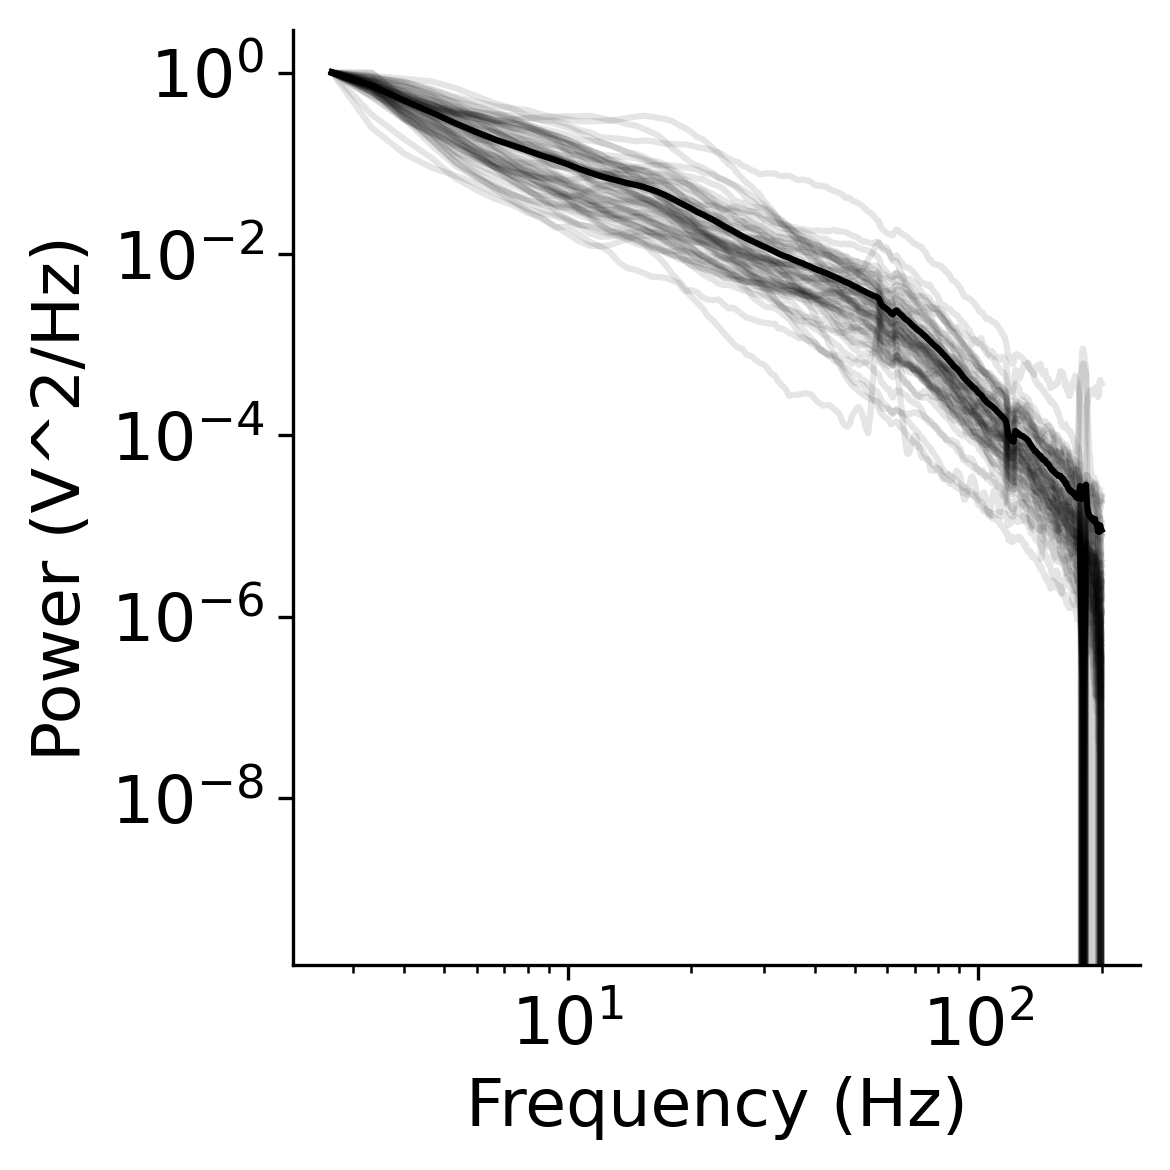

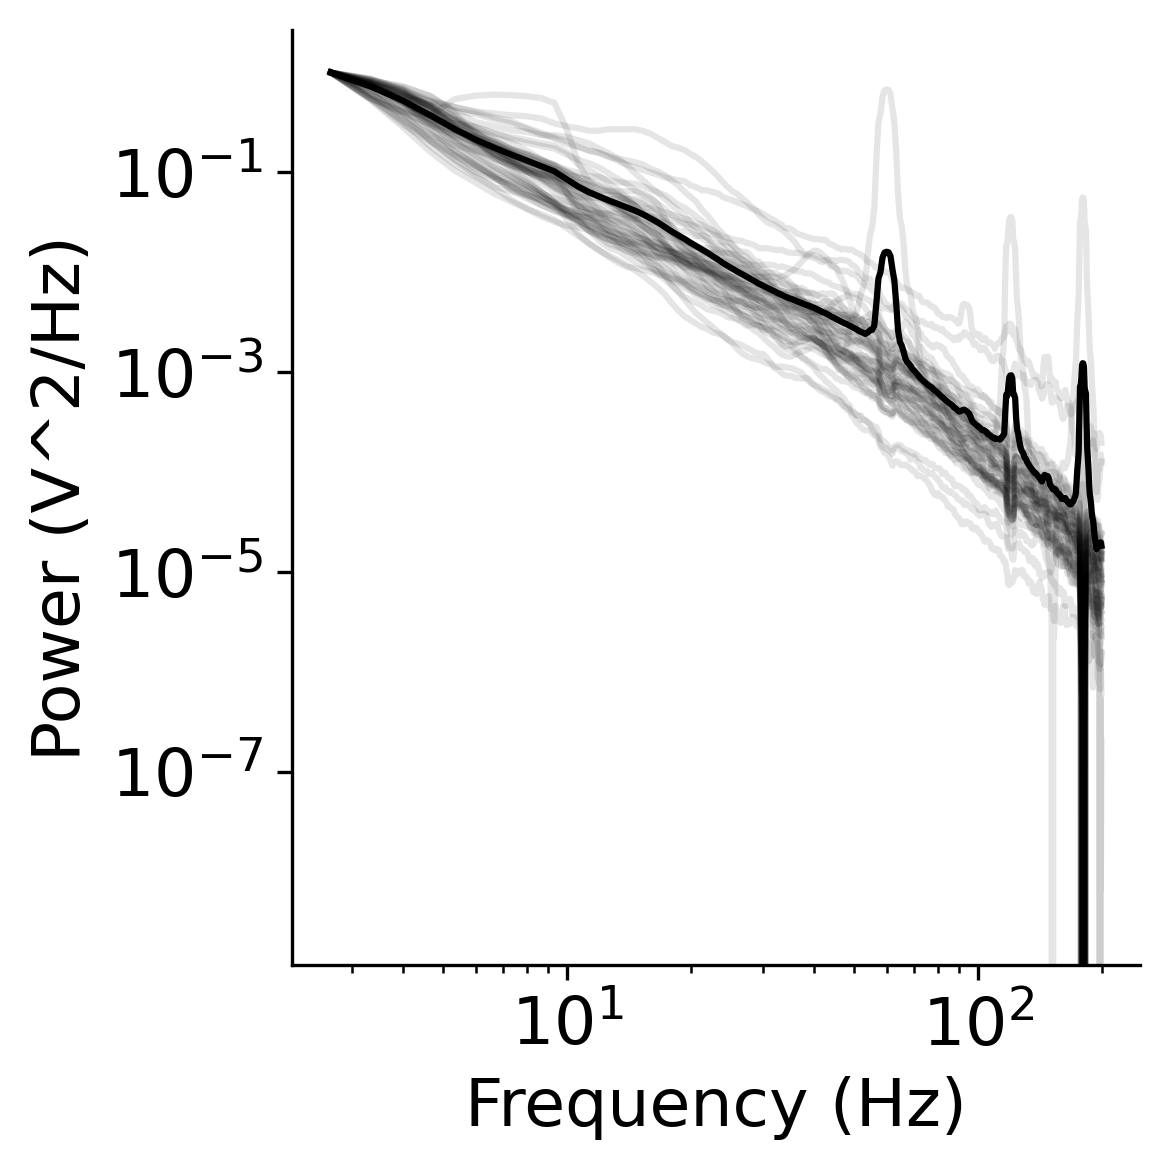

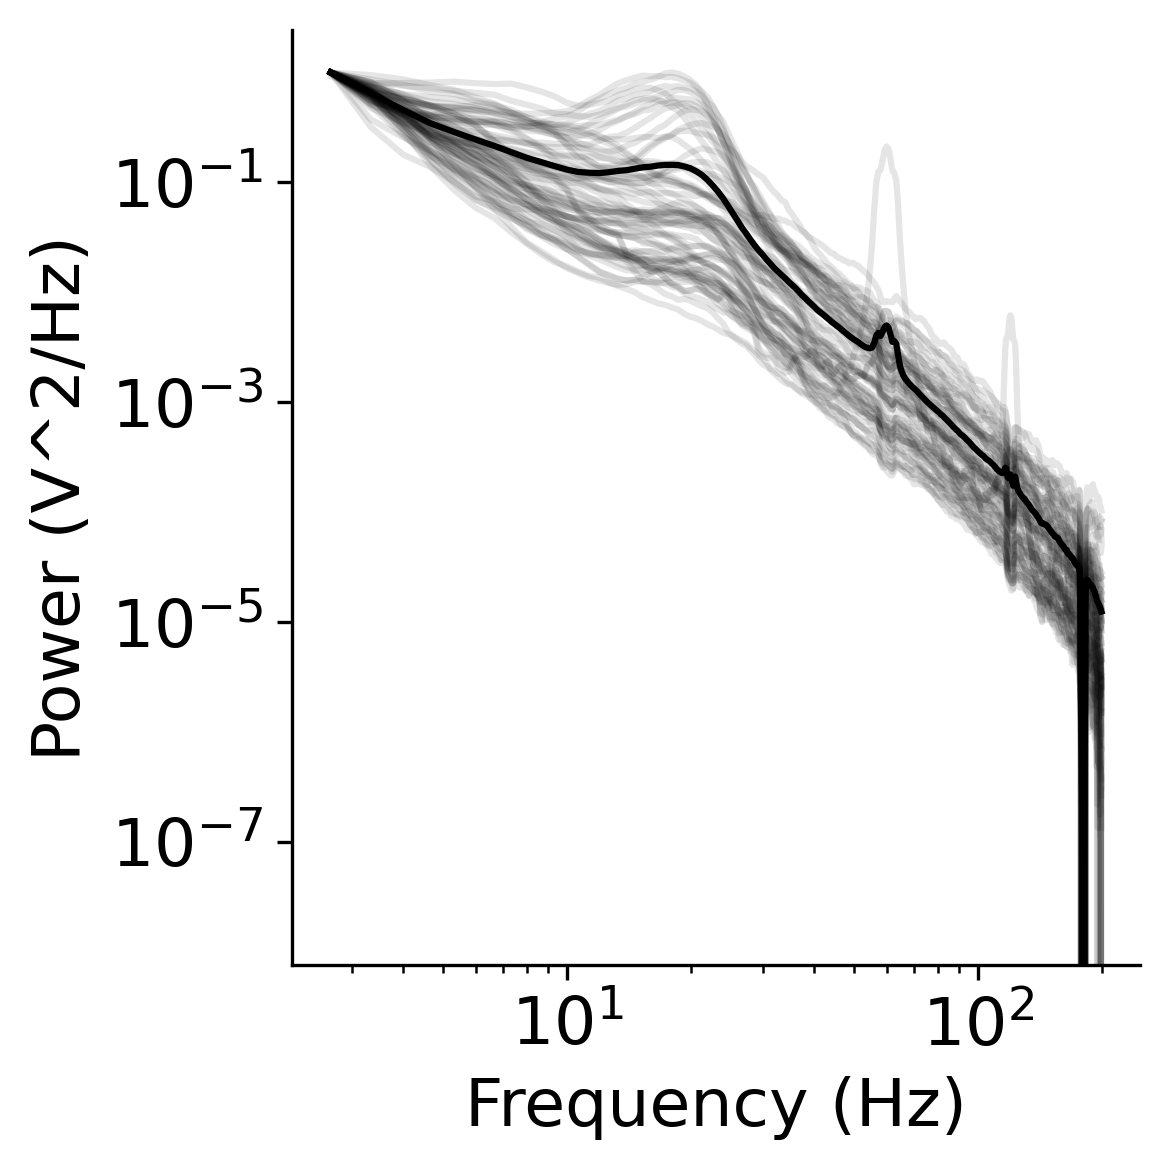

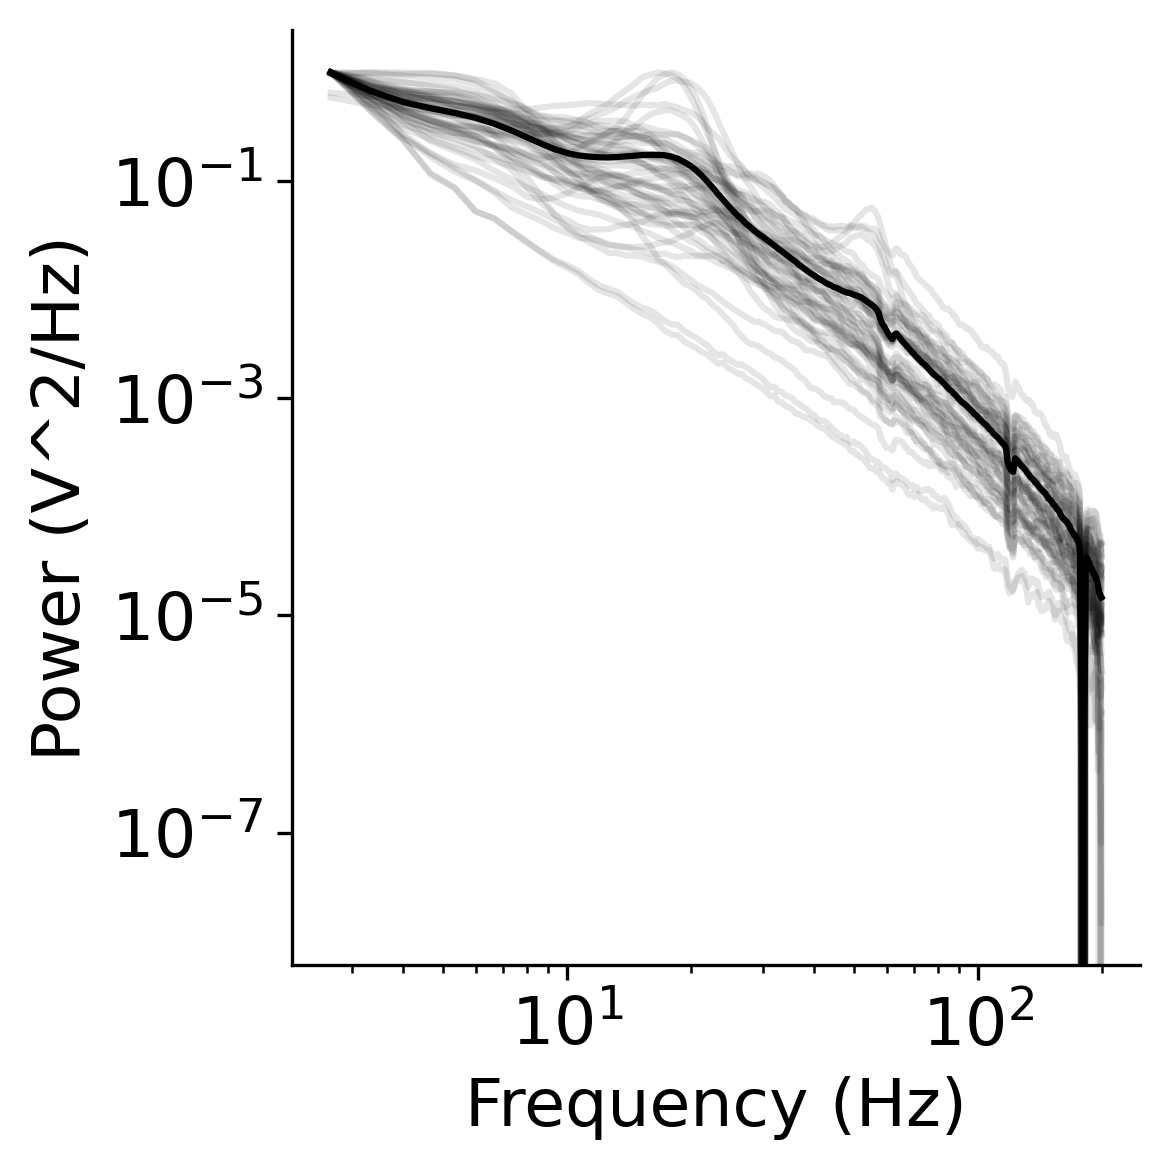

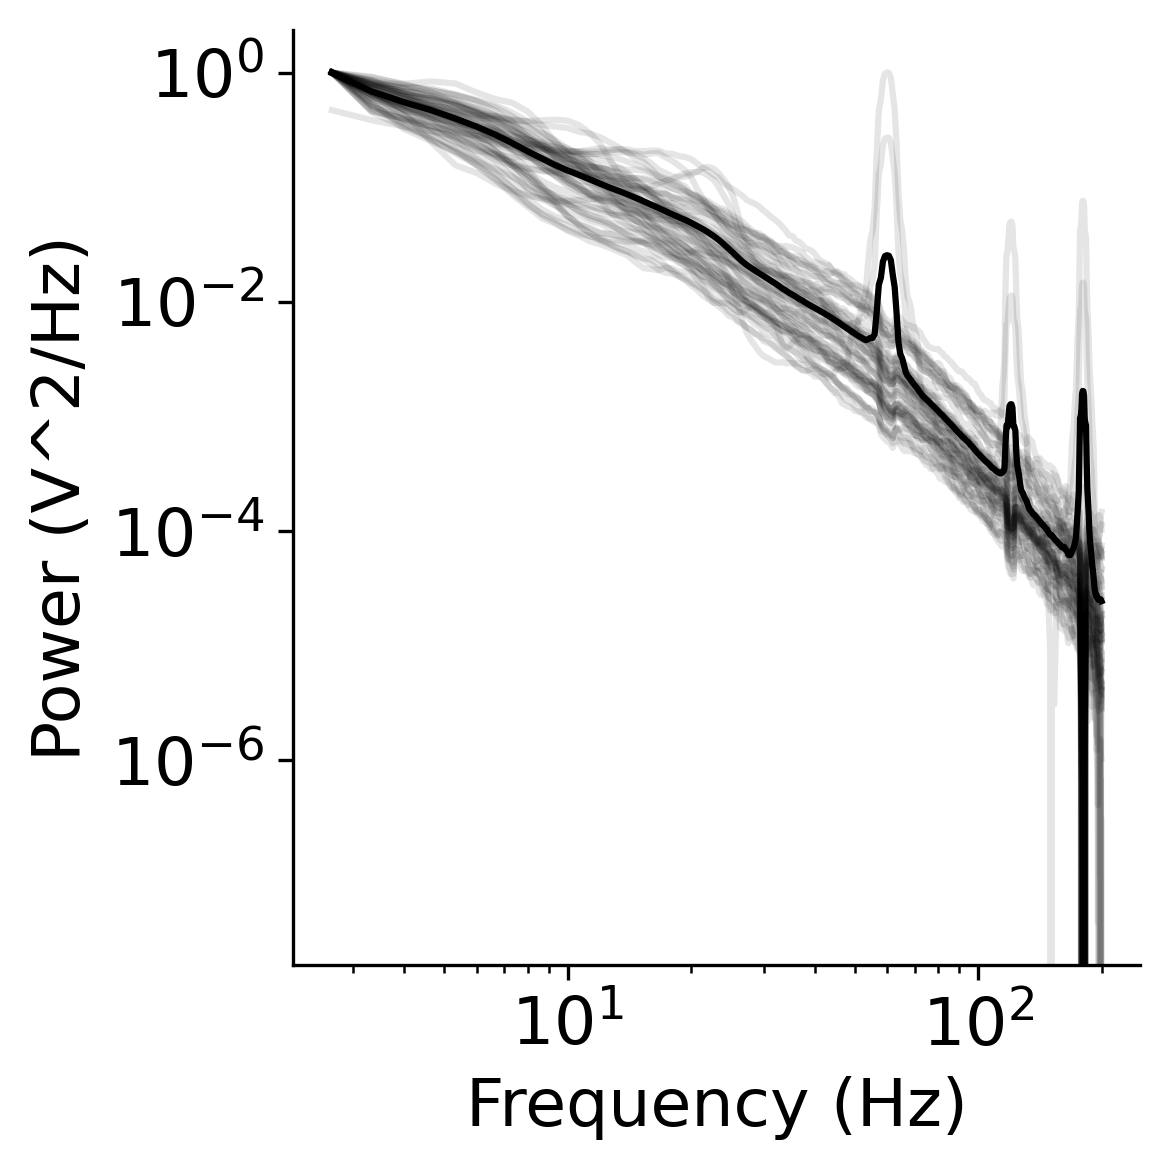

In [101]:
# freqs = np.logspace(*np.log10([2, 200]), num=30)
save_dir_plots = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/Plots'

for region in rois: 

    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
    # Create a Pandas DataFrame
    plot_data = np.vstack(psd_group_data[region])
    normalized_array = np.array([normalize_list(lst) for lst in plot_data])
    for ch in normalized_array:
        # plt.plot(freqs, np.log10(ch), alpha=0.1, color='k')
        plot_power_spectra(freqs, ch, alpha =0.1,  
                       ax=ax, colors='black')   
    plot_power_spectra(freqs, np.nanmean(normalized_array, axis=0), 
                       ax=ax, colors='black')   
    # plt.plot(freqs, np.log10(np.nanmean(normalized_array, axis=0)), alpha=1, color='k')

    # ax.set(title=f'{region}_nelec={n_elecs}')
    sns.despine()
    
    plt.savefig(f'{save_dir_plots}/feedback_PSD_{region}.pdf', dpi=300)

        
        

## Power spectrum (FOOOF)

Here, we are going to plot the group-level FOOOF analysis for two conditions in the task across all channels, and then also plot the individual power spectrums for each channel with model fit for each of the two conditions. Note the time specification to make sure I leave out the baseline period... 

FOOOF's primary utility, imo, is not in peak parameterization but 1/f subtraction. Peak parameters are subject to over- and under-fitting, and fit quality has too strong of an effect. Simply contrasting *n* PSDs (for *n* conditions) after removing the 1/f is a more healthy approach imo.

For guidance on picking the parameters used to fit: https://fooof-tools.github.io/fooof/auto_tutorials/plot_07-TroubleShooting.html#sphx-glr-auto-tutorials-plot-07-troubleshooting-py

## 1. FOOOF (produce dataframe and condition-specific plots)

In [7]:
%%time
ev_dict = {'feedback_start': [0, 1.5]}

# Define peak_width, peak_height, peak_threshold, max_n_peaks
FOOOF_kwargs = {'peak_width_limits': [1, 8], 
               'min_peak_height': 0.1,
                'peak_threshold': 1.,
                'max_n_peaks': 3,
               'freq_range': [1, 30]}
 
# Define our frequency bands of interest
band_dict = {'delta' : [1, 4],
               'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30]}

conditions = ['rpe>0',
             'rpe<1']

progress_bar = tqdm(subj_ids, ascii=True, desc='Computing FOOOF for all trials and subsetting by conditions')

for subj_id in progress_bar:
    # Load one person's data 
    for day in ['Day1']:
        load_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
        for event in ev_dict.keys():   
            filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/FOOOF/{event}'
            if not os.path.exists(f'{filepath}/plots'):
                os.makedirs(f'{filepath}/plots')
            if not os.path.exists(f'{filepath}/dfs'):
                os.makedirs(f'{filepath}/dfs')

            mne_data_reref = mne.read_epochs(f'{load_path}/{event}-epo.fif', preload=True)
            mne_data_reref.metadata = learn_df[learn_df.participant==subj_id]

            save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}'
            # Get electrode df 
            elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df')
            
            # # Run the FOOOF code in parallel
            Parallel(n_jobs=-1, verbose=1)(delayed(analysis_utils.compute_FOOOF_parallel)(chan, mne_data_reref, 
                                                                                         subj_id, 
                                                                                         elec_df, 
                                                                                         event, 
                                                                                         ev_dict, 
                                                                                         band_dict, 
                                                                                         conditions, 
                                                                                         do_plot=True, 
                                                                                         save_path='/sc/arion/projects/guLab/Salman/EphysAnalyses',
                                                                                         do_save=True, 
                                                                                         **FOOOF_kwargs) for chan in mne_data_reref.ch_names)


Computing FOOOF for all trials and subsetting by conditions:   0%|          | 0/21 [00:00<?, ?it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 28 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   28.7s finished
Computing FOOOF for all trials and subsetting by conditions:   5%|4         | 1/21 [00:29<09:41, 29.09s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI001/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 66 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:   24.9s finished
Computing FOOOF for all trials and subsetting by conditions:  10%|9         | 2/21 [00:55<08:39, 27.35s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.2s finished
Computing FOOOF for all trials and subsetting by conditions:  14%|#4        | 3/21 [00:56<04:38, 15.48s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 35 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   14.1s finished
Computing FOOOF for all trials and subsetting by conditions:  19%|#9        | 4/21 [01:11<04:22, 15.42s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 24 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    7.9s finished
Computing FOOOF for all trials and subsetting by conditions:  24%|##3       | 5/21 [01:20<03:24, 12.80s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI002/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 163 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 163 out of 163 | elapsed:  2.1min finished
Computing FOOOF for all trials and subsetting by conditions:  29%|##8       | 6/21 [03:26<12:49, 51.28s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 34 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    8.0s finished
Computing FOOOF for all trials and subsetting by conditions:  33%|###3      | 7/21 [03:35<08:45, 37.51s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 29 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    6.9s finished
Computing FOOOF for all trials and subsetting by conditions:  38%|###8      | 8/21 [03:43<06:05, 28.12s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/neural/Day1/feedback_start-epo.fif ...
    Reading extended channel information
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 18 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    3.4s finished
Computing FOOOF for all trials and subsetting by conditions:  43%|####2     | 9/21 [03:46<04:05, 20.46s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS023/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 65 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:   19.9s finished
Computing FOOOF for all trials and subsetting by conditions:  48%|####7     | 10/21 [04:07<03:47, 20.68s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI003/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 116 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:   49.8s finished
Computing FOOOF for all trials and subsetting by conditions:  52%|#####2    | 11/21 [04:58<04:57, 29.73s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS024/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 60 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   14.2s finished
Computing FOOOF for all trials and subsetting by conditions:  57%|#####7    | 12/21 [05:13<03:48, 25.40s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 58 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:   12.6s finished
Computing FOOOF for all trials and subsetting by conditions:  62%|######1   | 13/21 [05:27<02:55, 21.88s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 22 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    4.3s finished
Computing FOOOF for all trials and subsetting by conditions:  67%|######6   | 14/21 [05:33<01:58, 16.93s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS028/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 55 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   12.4s finished
Computing FOOOF for all trials and subsetting by conditions:  71%|#######1  | 15/21 [05:46<01:35, 15.94s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS030/neural/Day1/feedback_start-epo.fif ...
    Reading extended channel information
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 37 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:    8.8s finished
Computing FOOOF for all trials and subsetting by conditions:  76%|#######6  | 16/21 [05:55<01:09, 13.87s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI004/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 132 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:   44.7s finished
Computing FOOOF for all trials and subsetting by conditions:  81%|########  | 17/21 [06:40<01:33, 23.29s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS034/neural/Day1/feedback_start-epo.fif ...
    Reading extended channel information
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 39 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    8.9s finished
Computing FOOOF for all trials and subsetting by conditions:  86%|########5 | 18/21 [06:51<00:57, 19.33s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 58 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:   16.3s finished
Computing FOOOF for all trials and subsetting by conditions:  90%|######### | 19/21 [07:08<00:37, 18.79s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 52 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:   13.8s finished
Computing FOOOF for all trials and subsetting by conditions:  95%|#########5| 20/21 [07:23<00:17, 17.63s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 45 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.9s finished
Computing FOOOF for all trials and subsetting by conditions: 100%|##########| 21/21 [07:35<00:00, 21.70s/it]

CPU times: user 5.14 s, sys: 2.1 s, total: 7.24 s
Wall time: 7min 35s


In [10]:
ev_dict = {'feedback_start': [0, 1.5]}


With 25 cores, this took ~0.5 second / electrode

In [11]:
# Load the dataframes: 
chan_dfs = [] 
for subj_id in subj_ids:
    for day in ['Day1']:
        load_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
        for event in ev_dict.keys():   
            filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/FOOOF/{event}'
            elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df')
            for chan in tqdm(elec_df.label.unique(), ascii=True, desc='Loading FOOOF dataframes'): 
                chan_df = pd.read_csv(f'{filepath}/dfs/{chan}_df.csv')
                chan_dfs.append(chan_df)
chan_dfs = pd.concat(chan_dfs)



Loading FOOOF dataframes:   0%|          | 0/102 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/sc/arion/projects/guLab/Salman/EphysAnalyses/UI006/scratch/FOOOF/feedback_start/dfs/lfpx7-lfpx8_df.csv'

In [12]:
chan_dfs = pd.concat(chan_dfs)


In [93]:
roi_df = chan_dfs[chan_dfs['region'].isin(['AINS', 'dlPFC', 'OFC'])]


In [94]:
test_df = roi_df[(roi_df.in_FOOOF_peak==1) & ((roi_df.peak_freq>2) & ((roi_df.peak_freq<9))) & (roi_df.cond=='all')].groupby(['participant', 'channel', 'peak_freq', 'region']).mean().reset_index()




In [95]:
test_df

,participant,channel,peak_freq,region,frequency,PSD_raw,PSD_corrected,in_FOOOF_peak,peak_height,PSD_exp
0,MS016,lacas8-lacas9,5.769050,dlPFC,5.744256,1.106335,0.107457,1.0,0.108425,1.492292
1,MS016,lmolf3-lmolf4,4.077125,OFC,4.245754,1.627352,0.225875,1.0,0.258912,1.640590
2,MS017,lalps11-lalps12,5.120750,dlPFC,5.244755,1.394527,0.171523,1.0,0.197028,1.268134
3,MS017,lalps9-lalps10,4.626390,dlPFC,4.495504,1.595242,0.179044,1.0,0.208508,1.185179
4,MS019,lmoif3-lmoif4,6.226147,OFC,6.243756,1.350952,0.262398,1.0,0.234099,1.227025
...,...,...,...,...,...,...,...,...,...,...
64,MS036,lacas9-lacas10,7.301157,dlPFC,7.242757,0.917161,0.217709,1.0,0.230499,1.438898
65,MS036,laimm1-laimm2,4.429490,AINS,4.245754,1.682148,0.235800,1.0,0.258010,1.814968
66,MS036,racas10-racas11,7.907310,dlPFC,7.742258,0.657153,0.120401,1.0,0.118677,1.386040
67,MS036,racas11-racas12,4.939139,dlPFC,4.745255,1.396973,0.157241,1.0,0.175302,1.411160


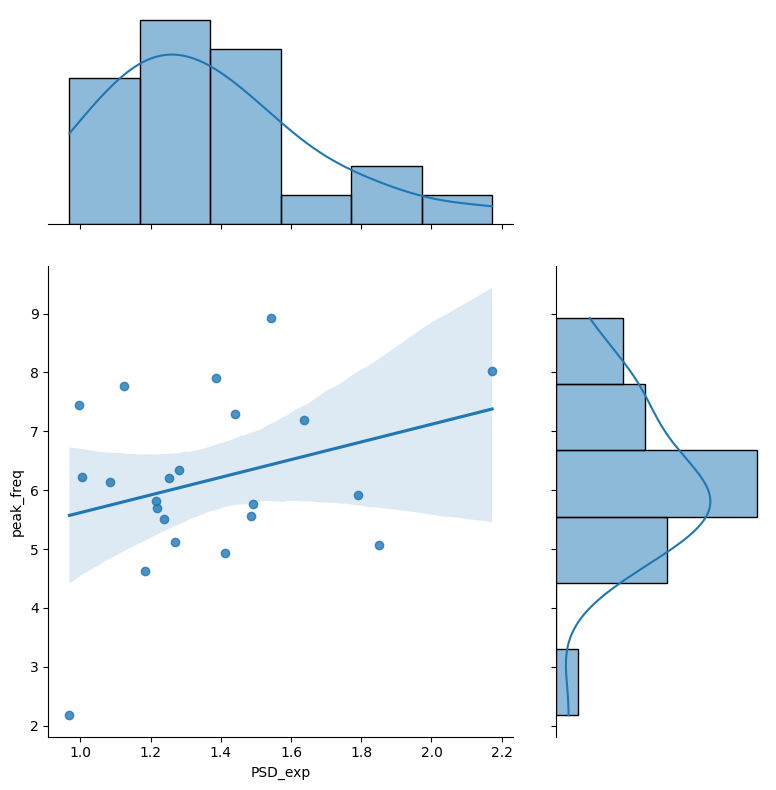

In [97]:
ax = sns.jointplot(data = test_df[test_df.region=='dlPFC'], 
                   x='PSD_exp', y='peak_freq', height=8, ratio=2, kind='reg')

# plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# # get the current positions of the joint ax and the ax for the marginal x
# pos_joint_ax = ax.ax_joint.get_position()
# pos_marg_x_ax = ax.ax_marg_x.get_position()
# # reposition the joint ax so it has the same width as the marginal x ax
# ax.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# # reposition the colorbar using new x positions and y positions of the joint ax
# ax.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])

[Text(0.5, 0, "['']")]

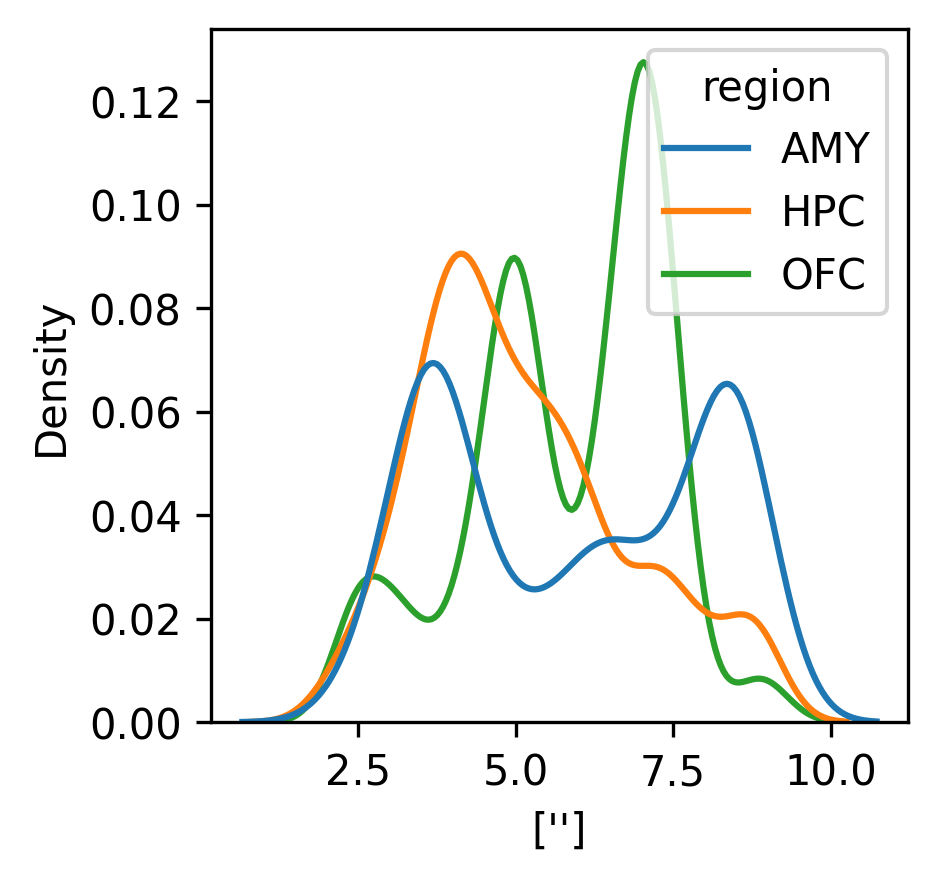

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)
sns.kdeplot(data=roi_df[(roi_df.in_FOOOF_peak==1) & ((roi_df.peak_freq>2) & ((roi_df.peak_freq<9)))],
            x='peak_freq', hue='region', ax=ax)
ax.set(xlabel=[''])


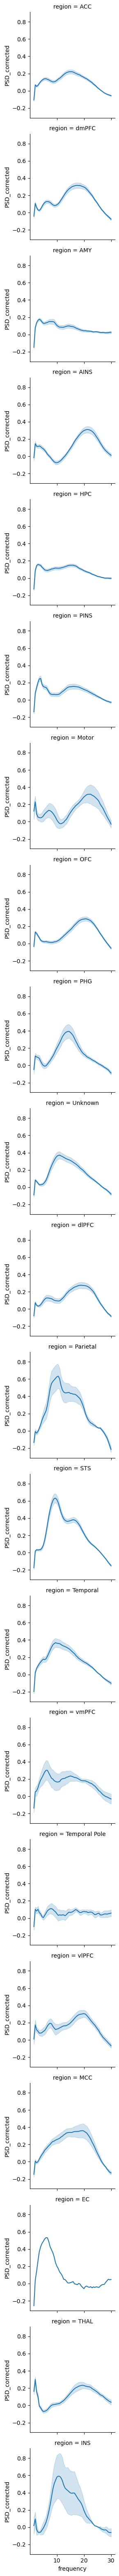

In [11]:
g = sns.FacetGrid(chan_dfs[chan_dfs.cond=='all'], row="region")
g.map(sns.lineplot, "frequency", "PSD_corrected",  errorbar='se')



In [48]:
grouped_df = chan_dfs.groupby(['region', 'channel', 'cond', 'in_FOOOF_peak']).mean().reset_index().drop(columns=['in_FOOOF_peak', 'frequency', 'PSD_raw'])


                                                                                 
                                                                                 

In [49]:
grouped_df[grouped_df.peak_freq!=0]

,region,channel,cond,PSD_corrected,peak_freq,peak_height,PSD_exp
1,ACC,lacam1-lacam2,all,0.192104,3.844139,0.215071,1.766096
2,ACC,lacam1-lacam2,all,0.269256,15.856015,0.293497,1.766096
3,ACC,lacam1-lacam2,all,0.144445,21.099806,0.134807,1.766096
5,ACC,lacam1-lacam2,rpe<1,0.192104,3.844139,0.215071,1.766096
6,ACC,lacam1-lacam2,rpe<1,0.269256,15.856015,0.293497,1.766096
...,...,...,...,...,...,...,...
10013,vmPFC,rmoif2-rmoif3,rpe<1,0.555005,14.769243,0.589678,1.279201
10014,vmPFC,rmoif2-rmoif3,rpe<1,0.399347,20.387378,0.377183,1.279201
10016,vmPFC,rmoif2-rmoif3,rpe>0,0.253865,6.044580,0.265918,1.224281
10017,vmPFC,rmoif2-rmoif3,rpe>0,0.536915,14.268380,0.574685,1.224281


In [153]:
# # Fit an individual channel (for plotting)
# ind_fits = FOOOFGroup_res.get_fooof(ind=0, regenerate=True)
# ind_fits.fit()

In [154]:
# ind_fits.plot()